# Heuristic learning

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping


# 1200 dataset attempt cnn

In [4]:
dataset = np.load("star_battle_dataset.npz", allow_pickle=True)
puzzles = dataset["puzzles"]
solutions = dataset["solutions"]
# Check the shape of the dataset
print("Puzzles shape:", puzzles.shape)
print("Solutions shape:", solutions.shape)

Puzzles shape: (2500, 10, 10)
Solutions shape: (2500, 10, 10)


## data pre processing

In [40]:
# augment data for larger dataset
def augment_data(puzzles, solutions):
    augmented_puzzles = []
    augmented_solutions = []
    
    for i in range(len(puzzles)):
        puzzle = puzzles[i]
        solution = solutions[i]
        
        # original puzzle
        augmented_puzzles.append(puzzle)
        augmented_solutions.append(solution)
        
        # horizontal Flip
        augmented_puzzles.append(np.fliplr(puzzle))
        augmented_solutions.append(np.fliplr(solution))
        
        # vertical Flip
        augmented_puzzles.append(np.flipud(puzzle))
        augmented_solutions.append(np.flipud(solution))
        
        # rotate 90 degrees
        augmented_puzzles.append(np.rot90(puzzle, k=1))
        augmented_solutions.append(np.rot90(solution, k=1))
        
        # rotate 180 degrees
        augmented_puzzles.append(np.rot90(puzzle, k=2))
        augmented_solutions.append(np.rot90(solution, k=2))
        
        # rotate 270 degrees
        augmented_puzzles.append(np.rot90(puzzle, k=3))
        augmented_solutions.append(np.rot90(solution, k=3))
    
    return np.array(augmented_puzzles), np.array(augmented_solutions)

# apply augmentation to your dataset
augmented_puzzles, augmented_solutions = augment_data(puzzles, solutions)

print("Original puzzle count:", len(puzzles))
print("Augmented puzzle count:", len(augmented_puzzles))


Original puzzle count: 1200
Augmented puzzle count: 7200


In [ ]:
augmented_puzzles = puzzles[..., np.newaxis] 
augmented_solutions = solutions[..., np.newaxis] 

# Normalize puzzle values between 0 and 1
augmented_puzzles = puzzles.astype(np.float32) / 9.0

augmented_solutions = solutions.astype(np.float32) 

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(augmented_puzzles, augmented_solutions, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")


Training data shape: (960, 10, 10, 1), (960, 10, 10, 1)
Testing data shape: (240, 10, 10, 1), (240, 10, 10, 1)


## build model

In [ ]:
# Build the CNN model
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(10, 10, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(100, activation='sigmoid'),  # predicts 100 cells
    layers.Reshape((10, 10, 1))  # reshape back to 10x10 grid
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summarise model
model.summary()



c:\Users\smjw21\OneDrive - University of Sussex\individualproject\StarBattle\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 10, 10, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5, 5, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 128)      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 10, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,212 (383.64 KB)

 Trainable params: 97,700 (381.64 KB)

 Non-trainable params: 512 (2.00 KB)

## train model

In [ ]:
# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
30/30 [==============================] - 3s 41ms/step - loss: 0.6321 - accuracy: 0.7105 - val_loss: 0.6663 - val_accuracy: 0.6349
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.5165 - accuracy: 0.7885 - val_loss: 0.6531 - val_accuracy: 0.6305
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.4893 - accuracy: 0.7966 - val_loss: 0.6357 - val_accuracy: 0.6641
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.4729 - accuracy: 0.8001 - val_loss: 0.6262 - val_accuracy: 0.6658
Epoch 5/20
30/30 [==============================] - 0s 12ms/step - loss: 0.4569 - accuracy: 0.8030 - val_loss: 0.6222 - val_accuracy: 0.6737
Epoch 6/20
30/30 [==============================] - 0s 12ms/step - loss: 0.4422 - accuracy: 0.8077 - val_loss: 0.6201 - val_accuracy: 0.6817
Epoch 7/20
30/30 [==============================] - 0s 11ms/step - loss: 0.4264 - accuracy: 0.8136 - val_loss: 0.6219 - val_accuracy: 0.6806
Epoch 8/20
30

## evaluate model

In [ ]:
# Evaluate on test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


8/8 [==============================] - 0s 4ms/step - loss: 0.6561 - accuracy: 0.7250
Test Accuracy: 0.7250


# 2500 dataset attempt

check if increase in data set significantly improves the model

In [ ]:
dataset = np.load("star_battle_dataset.npz", allow_pickle=True)
puzzles = dataset["puzzles"]
solutions = dataset["solutions"]

print("Puzzles shape:", puzzles.shape)
print("Solutions shape:", solutions.shape)

Puzzles shape: (2500, 10, 10)
Solutions shape: (2500, 10, 10)


## preprocessing

In [14]:
# augment data for larger dataset
def augment_data(puzzles, solutions):
    augmented_puzzles = []
    augmented_solutions = []
    
    for i in range(len(puzzles)):
        puzzle = puzzles[i]
        solution = solutions[i]
        
        # original puzzle
        augmented_puzzles.append(puzzle)
        augmented_solutions.append(solution)
        
        # horizontal Flip
        augmented_puzzles.append(np.fliplr(puzzle))
        augmented_solutions.append(np.fliplr(solution))
        
        # vertical Flip
        augmented_puzzles.append(np.flipud(puzzle))
        augmented_solutions.append(np.flipud(solution))
        
        # rotate 90 degrees
        augmented_puzzles.append(np.rot90(puzzle, k=1))
        augmented_solutions.append(np.rot90(solution, k=1))
        
        # rotate 180 degrees
        augmented_puzzles.append(np.rot90(puzzle, k=2))
        augmented_solutions.append(np.rot90(solution, k=2))
        
        # rotate 270 degrees
        augmented_puzzles.append(np.rot90(puzzle, k=3))
        augmented_solutions.append(np.rot90(solution, k=3))
    
    return np.array(augmented_puzzles), np.array(augmented_solutions)

# apply augmentation to your dataset
augmented_puzzles, augmented_solutions = augment_data(puzzles, solutions)

print("Original puzzle count:", len(puzzles))
print("Augmented puzzle count:", len(augmented_puzzles))


Original puzzle count: 2500
Augmented puzzle count: 15000


In [ ]:
augmented_puzzles2500 = augmented_puzzles[..., np.newaxis]
augmented_solutions2500 = augmented_solutions[..., np.newaxis]  

# Normalize puzzle values between 0 and 1 
augmented_puzzles2500 = puzzles.astype(np.float32) / 9.0

augmented_solutions2500 = solutions.astype(np.float32) 

X_train, X_test, y_train, y_test = train_test_split(augmented_puzzles2500, augmented_solutions2500, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (2000, 10, 10), (2000, 10, 10)
Testing data shape: (500, 10, 10), (500, 10, 10)


## replicate model

In [ ]:
# Build the CNN model
model2 = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(10, 10, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(100, activation='sigmoid'),  
    layers.Reshape((10, 10, 1))  
])

# Compile model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summarise
model2.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 5, 5, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 2, 2, 128)      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 10, 10, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,212 (383.64 KB)

 Trainable params: 97,700 (381.64 KB)

 Non-trainable params: 512 (2.00 KB)

## train model

In [30]:
history = model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6940 - loss: 0.6424 - val_accuracy: 0.6529 - val_loss: 0.6498
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7959 - loss: 0.5091 - val_accuracy: 0.6807 - val_loss: 0.6180
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7986 - loss: 0.4941 - val_accuracy: 0.7088 - val_loss: 0.5977
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7995 - loss: 0.4862 - val_accuracy: 0.7217 - val_loss: 0.5832
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8005 - loss: 0.4762 - val_accuracy: 0.7367 - val_loss: 0.5701
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8014 - loss: 0.4683 - val_accuracy: 0.7547 - val_loss: 0.5558
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8041 - loss: 0.4585 - val_accuracy: 0.7781 - val_loss: 0.5390
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8053 - loss: 0.4512 - val_accuracy: 0.7844 - val_loss: 0.5327
Epo

## evaluate model

In [ ]:
# Evaluate
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7379 - loss: 0.6922 
Test Accuracy: 0.7377


# New approach

## u-net architecture with learning

## data preprocessing

In [ ]:
dataset = np.load("star_battle_dataset.npz", allow_pickle=True)
puzzles = dataset["puzzles"]
solutions = dataset["solutions"]

print("Puzzles shape:", puzzles.shape)
print("Solutions shape:", solutions.shape)

Puzzles shape: (2500, 10, 10)
Solutions shape: (2500, 10, 10)


In [7]:
# augment data for larger dataset
def augment_data(puzzles, solutions):
    augmented_puzzles = []
    augmented_solutions = []
    
    for i in range(len(puzzles)):
        puzzle = puzzles[i]
        solution = solutions[i]
        
        # original puzzle
        augmented_puzzles.append(puzzle)
        augmented_solutions.append(solution)
        
        # horizontal Flip
        augmented_puzzles.append(np.fliplr(puzzle))
        augmented_solutions.append(np.fliplr(solution))
        
        # vertical Flip
        augmented_puzzles.append(np.flipud(puzzle))
        augmented_solutions.append(np.flipud(solution))
        
        # rotate 90 degrees
        augmented_puzzles.append(np.rot90(puzzle, k=1))
        augmented_solutions.append(np.rot90(solution, k=1))
        
        # rotate 180 degrees
        augmented_puzzles.append(np.rot90(puzzle, k=2))
        augmented_solutions.append(np.rot90(solution, k=2))
        
        # rotate 270 degrees
        augmented_puzzles.append(np.rot90(puzzle, k=3))
        augmented_solutions.append(np.rot90(solution, k=3))
    
    return np.array(augmented_puzzles), np.array(augmented_solutions)

# apply augmentation to your dataset
augmented_puzzles, augmented_solutions = augment_data(puzzles, solutions)

print("Original puzzle count:", len(puzzles))
print("Augmented puzzle count:", len(augmented_puzzles))


Original puzzle count: 2500
Augmented puzzle count: 15000


In [8]:
print(augmented_puzzles.shape)
print(augmented_solutions.shape)

(15000, 10, 10)
(15000, 10, 10)


In [ ]:
augmented_puzzles = augmented_puzzles[..., np.newaxis] 
augmented_solutions = augmented_solutions[..., np.newaxis]  

X = augmented_puzzles.astype(np.float32).reshape(-1, 10, 10, 1) / 9.0
y = augmented_solutions.astype(np.float32).reshape(-1, 10, 10, 1)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1111, random_state=42, shuffle=True)

# Check splits
print(f"Train size: {len(X_train)}")
print(f"Val size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

# print(X_train.shape)

Train size: 12000
Val size: 1500
Test size: 1500


## building unet architecture model

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_unet(input_shape=(10, 10, 1), filters=64, learning_rate=0.001, dropout_rate=0.5, optimizer='adam'):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    c2 = layers.Conv2D(filters * 2, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c2)

    # Decoder
    u1 = layers.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(p1)
    m1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(m1)
    
    # Dropout
    c3 = layers.Dropout(dropout_rate)(c3)

    c4 = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(c3)

    # optimizer
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    model = models.Model(inputs=inputs, outputs=c4)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [13]:
model = build_unet()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## model training and hyperparameter tuning

In [14]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [15]:
# train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7921 - loss: 0.5175 - val_accuracy: 0.8002 - val_loss: 0.4852
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8004 - loss: 0.4856 - val_accuracy: 0.8010 - val_loss: 0.4763
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8012 - loss: 0.4766 - val_accuracy: 0.8018 - val_loss: 0.4691
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8021 - loss: 0.4703 - val_accuracy: 0.8030 - val_loss: 0.4644
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8030 - loss: 0.4642 - val_accuracy: 0.8038 - val_loss: 0.4631
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8043 - loss: 0.4593 - val_accuracy: 0.8047 - val_loss: 0.4585
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8057 - loss: 0.4540 - val_accuracy: 0.8065 - val_loss: 0.4544
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8073 - loss: 0.4497 - val_accuracy: 0.

In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_val.flatten(), model.predict(X_val).flatten() > 0.5))


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89    120000
         1.0       0.61      0.18      0.27     30000

    accuracy                           0.81    150000
   macro avg       0.72      0.57      0.58    150000
weighted avg       0.78      0.81      0.77    150000



## hyperparameter tuning

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Model function with hyperparameters changable
def build_unet(input_shape=(10, 10, 1), filters=64, learning_rate=0.001, dropout_rate=0.5, optimizer='adam'):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    c2 = layers.Conv2D(filters * 2, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c2)

    # Decoder
    u1 = layers.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(p1)
    m1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(m1)
    
    # Dropout
    c3 = layers.Dropout(dropout_rate)(c3)

    c4 = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(c3)

    # optimizer
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    model = models.Model(inputs=inputs, outputs=c4)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Manually loop hyperparameters
param_grid = {
    'learning_rate': [0.001],
    'filters': [32, 128],
    'batch_size': [16, 64],
    'epochs': [30],
    'dropout_rate': [0.3, 0.5],
    'optimizer': ['adam'],
}

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

best_score = 0
best_params = {}

# Grid Search
for lr in param_grid['learning_rate']:
    for f in param_grid['filters']:
        for bs in param_grid['batch_size']:
            for ep in param_grid['epochs']:
                for dr in param_grid['dropout_rate']:
                    for opt in param_grid['optimizer']:
                        print(f"Training with lr={lr}, filters={f}, batch_size={bs}, epochs={ep}, dropout={dr}, optimizer={opt}")
                        
                        model = build_unet(input_shape=(10, 10, 1), filters=f, learning_rate=lr, dropout_rate=dr, optimizer=opt)
                        model.fit(X_train, y_train, epochs=ep, batch_size=bs, validation_data=(X_val, y_val), callbacks=[early_stopping])
                        
                        # Evaluate model
                        score = model.evaluate(X_val, y_val, verbose=0)
                        if score[1] > best_score: 
                            best_score = score[1]
                            best_params = {'learning_rate': lr, 'filters': f, 'batch_size': bs, 'epochs': ep, 'dropout_rate': dr, 'optimizer': opt}

print(f"Best parameters: {best_params} with accuracy: {best_score}")


Training with lr=0.001, filters=32, batch_size=16, epochs=30, dropout=0.3, optimizer=adam
Epoch 1/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7941 - loss: 0.5116 - val_accuracy: 0.8005 - val_loss: 0.4816
Epoch 2/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8006 - loss: 0.4813 - val_accuracy: 0.8018 - val_loss: 0.4730
Epoch 3/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8014 - loss: 0.4727 - val_accuracy: 0.8024 - val_loss: 0.4673
Epoch 4/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8027 - loss: 0.4656 - val_accuracy: 0.8032 - val_loss: 0.4615
Epoch 5/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8041 - loss: 0.4597 - val_accuracy: 0.8046 - val_loss: 0.4574
Epoch 6/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8056 - loss: 0.4543 - val_accuracy: 0.8056 - val_loss: 0.4542
Epoch 7/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8070 - loss: 0.4495 - val_accuracy: 0.8069 - val_loss: 0.4500
Epoch 8/30
844

## Final model


In [ ]:
# Final best hyperparameters
params = {
    'filters': 32,
    'learning_rate': 0.001,
    'dropout_rate': 0.3,
    'optimizer': 'adam',
    'batch_size': 16,
    'epochs': 30,
}

# Define final model
def build_unet(input_shape=(10, 10, 1), filters=32, learning_rate=0.001, dropout_rate=0.3, optimizer='adam'):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    c2 = layers.Conv2D(filters * 2, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c2)

    # Decoder
    u1 = layers.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same')(p1)
    m1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(m1)
    c3 = layers.Dropout(dropout_rate)(c3)

    # Final output layer
    outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(c3)

    # Optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [73]:
# Build final model
model = build_unet(
    input_shape=(10, 10, 1),
    filters=params['filters'],
    learning_rate=params['learning_rate'],
    dropout_rate=params['dropout_rate'],
    optimizer=params['optimizer']
)

print(model.summary())


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 10, 10, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 10, 10,    │        320 │ input_layer_20[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 10, 10,    │     18,496 │ conv2d_79[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 5, 5, 64)  │          0 │ conv2d_80[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_19 │ (None, 10, 10,    │     18,464 │ max_pooling2d_21… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 10, 10,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 96)               │            │ conv2d_80[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 10, 10,    │     27,680 │ concatenate_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 10, 10,    │          0 │ conv2d_81[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 10, 10, 1) │        289 │ dropout_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 65,249 (254.88 KB)

 Trainable params: 65,249 (254.88 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 10, 10, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 10, 10,    │        320 │ input_layer_20[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 10, 10,    │     18,496 │ conv2d_79[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 5, 5, 64)  │          0 │ conv2d_80[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_19 │ (None, 10, 10,    │     18,464 │ max_pooling2d_21… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 10, 10,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 96)               │            │ conv2d_80[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 10, 10,    │     27,680 │ concatenate_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 10, 10,    │          0 │ conv2d_81[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 10, 10, 1) │        289 │ dropout_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 65,249 (254.88 KB)

 Trainable params: 65,249 (254.88 KB)

 Non-trainable params: 0 (0.00 B)

None


In [64]:
# Train on full dataset or training + validation
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=params['epochs'],
    batch_size=params['batch_size'],
    callbacks=[early_stopping]
)

Epoch 1/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7963 - loss: 0.5115 - val_accuracy: 0.8004 - val_loss: 0.4844
Epoch 2/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8006 - loss: 0.4815 - val_accuracy: 0.8013 - val_loss: 0.4737
Epoch 3/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8016 - loss: 0.4719 - val_accuracy: 0.8025 - val_loss: 0.4668
Epoch 4/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8029 - loss: 0.4646 - val_accuracy: 0.8038 - val_loss: 0.4613
Epoch 5/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8044 - loss: 0.4586 - val_accuracy: 0.8054 - val_loss: 0.4546
Epoch 6/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8061 - loss: 0.4527 - val_accuracy: 0.8063 - val_loss: 0.4512
Epoch 7/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8073 - loss: 0.4483 - val_accuracy: 0.8074 - val_loss: 0.4476
Epoch 8/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8085 - loss: 0.4440 - val_accuracy: 0.

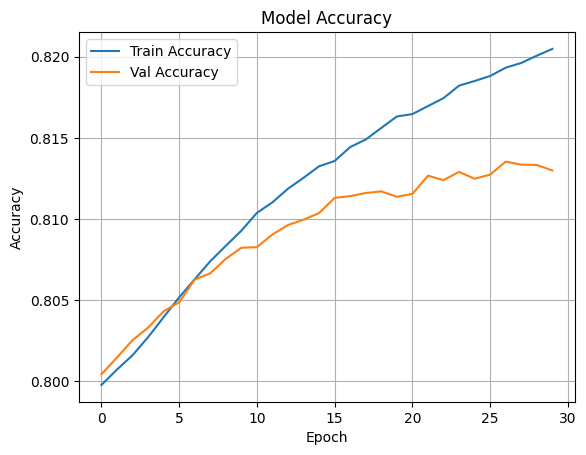

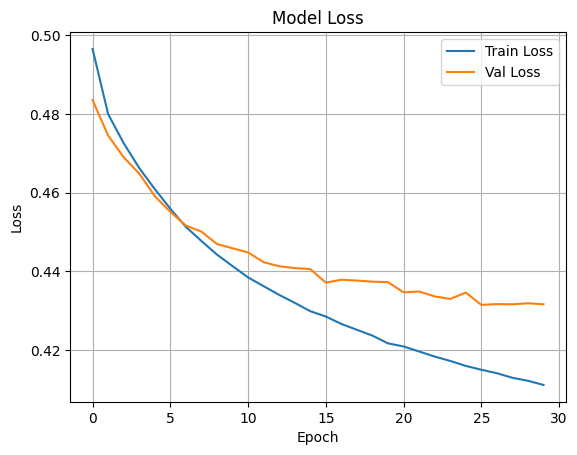

In [21]:
#plotting tarining curves
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



In [24]:

from sklearn.metrics import classification_report

print(classification_report(y_val.flatten(), model.predict(X_val).flatten() > 0.5))


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89    120000
         1.0       0.63      0.16      0.25     30000

    accuracy                           0.81    150000
   macro avg       0.72      0.57      0.57    150000
weighted avg       0.78      0.81      0.76    150000



47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


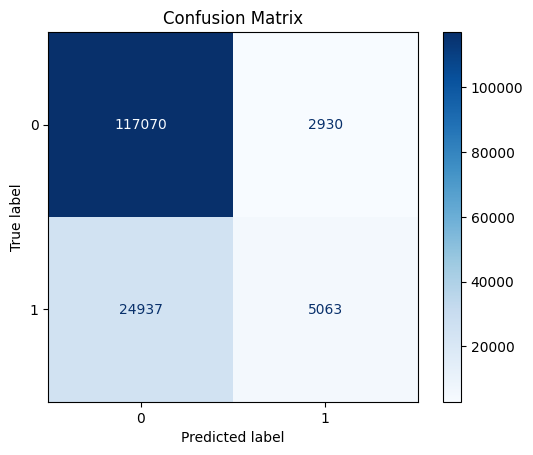

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_true = y_test.flatten()     
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).flatten()  

# confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()


# predict on test set of data

In [ ]:
# Predictions
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test.flatten(), y_pred.flatten() > 0.5))



47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89    120000
         1.0       0.63      0.17      0.27     30000

    accuracy                           0.81    150000
   macro avg       0.73      0.57      0.58    150000
weighted avg       0.79      0.81      0.77    150000



## gridcam visualisation??

In [2]:
# gridcam visualisation
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def get_gradcam(model, image, layer_name):

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    image = tf.convert_to_tensor(image[np.newaxis, ...])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = tf.reduce_mean(predictions)

    #gradients
    grads = tape.gradient(loss, conv_outputs)

    # average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight outpputs
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    return heatmap


def plot_gradcam(input_grid, heatmap, overlay=True,  alpha=0.6):
    heatmap_resized = cv2.resize(heatmap, (input_grid.shape[1], input_grid.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_HSV)

    if overlay:
        if input_grid.shape[-1] == 1:
            input_rgb = np.repeat(input_grid, 3, axis=-1)
        else:
            input_rgb = input_grid

        input_rgb = np.uint8(255 * input_rgb)
        heatmap_overlay = cv2.addWeighted(input_rgb, 1 - alpha, heatmap_color, alpha, 0)

        fig, axs = plt.subplots(1, 2, figsize=(8, 4))

        axs[0].imshow(input_rgb)
        axs[0].set_title("Original Puzzle")
        axs[0].axis('off')

        axs[1].imshow(heatmap_overlay)
        axs[1].set_title("Grad-CAM Overlay")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

    else:
        if input_grid.shape[-1] == 1:
            input_rgb = np.repeat(input_grid, 3, axis=-1)
        else:
            input_rgb = input_grid

        input_rgb = np.uint8(255 * input_rgb)
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))

        axs[0].imshow(input_rgb)
        axs[0].set_title("Original Puzzle")
        axs[0].axis('off')

        axs[1].imshow(heatmap_resized)
        axs[1].set_title("Heatmap Overlay")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()
        




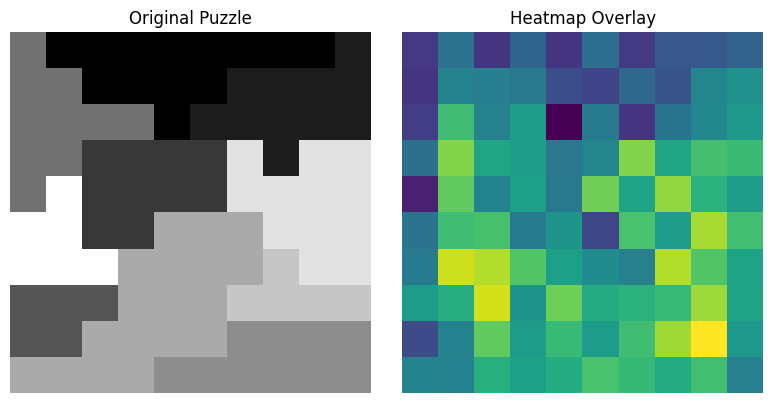

Predicted class for sample 0: 72


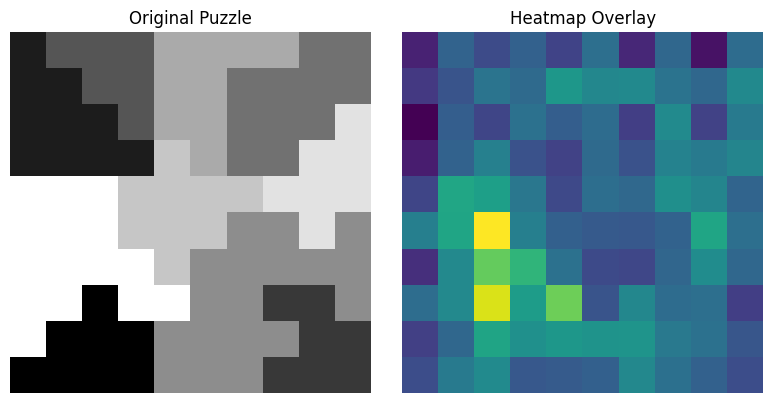

Predicted class for sample 1: 53


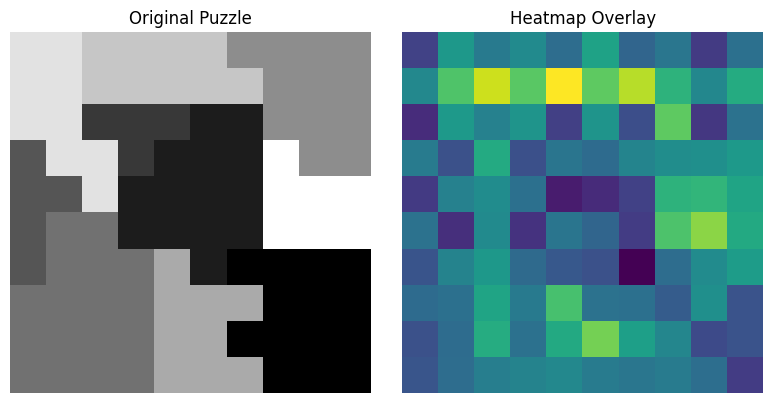

Predicted class for sample 2: 60


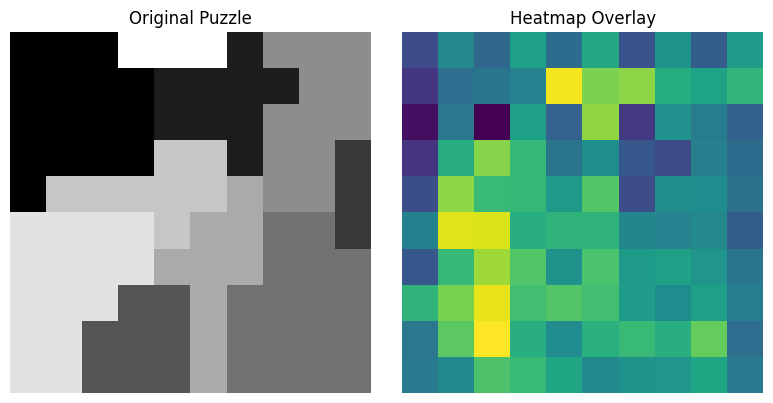

Predicted class for sample 3: 3


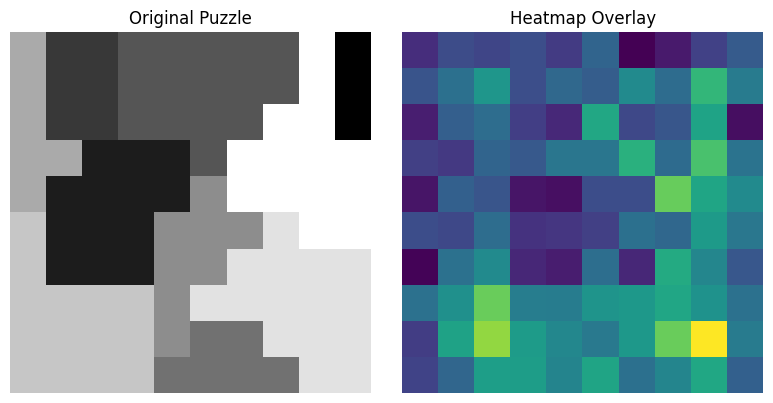

Predicted class for sample 4: 29


In [ ]:

# we visualise the last layer
for i in range(5): #first 5 test samples
    image = X_test[i]  
    heatmap = get_gradcam(model, image, 'conv2d_82')  

    # display side by side
    plot_gradcam(image, heatmap,overlay=False, alpha=0.6)
    
    print(f"Predicted class for sample {i}: {np.argmax(y_pred[i])}")


In [81]:
print(y_pred.shape)

(1500, 10, 10, 1)


c:\Users\smjw21\OneDrive - University of Sussex\individualproject\StarBattle\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_183']]
Received: inputs=Tensor(shape=(1, 10, 10, 1))
  warnings.warn(msg)


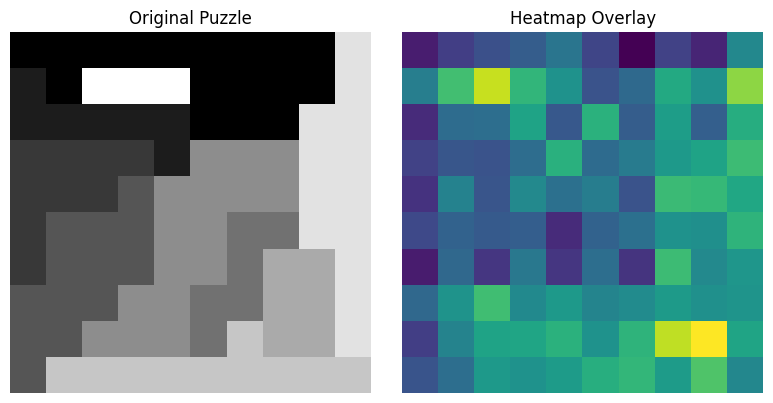

In [106]:
# finding the best prediction
confidence_scores = np.max(y_pred, axis=(1, 2, 3))
best_index = np.argmax(confidence_scores)

best_image = X_test[best_index]

heatmap = get_gradcam(model, best_image, layer_name='conv2d_82') 
plot_gradcam(best_image, heatmap, overlay=False)